In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/Sales target.csv
/kaggle/input/ecommerce-data/Order Details.csv
/kaggle/input/ecommerce-data/List of Orders.csv


Imports

In [2]:
!pip install GPyOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 5.8 MB/s eta 0:00:00
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83644 sha256=1a9f7e87bd5ea9892446115eba163bce11c76658d1d15c0e79d666cecf157496
  Stored in directory: /root/.cache/pip/wheels/72/17/52/9d818b4c60f733bf49d5cf82bc2758ebbdc57a0471137c37be
Successfully built GPyOpt


In [3]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from catboost import CatBoostRegressor, Pool, cv
from catboost import MetricVisualizer

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from os import listdir

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import shap
shap.initjs()
import GPyOpt

In [4]:
order_sales = pd.read_csv("/kaggle/input/ecommerce-data/Order Details.csv", dtype={'Order ID': str})
print(order_sales.shape)

demo = pd.read_csv("/kaggle/input/ecommerce-data/List of Orders.csv")
print(demo.shape)

target = pd.read_csv("/kaggle/input/ecommerce-data/Sales target.csv")
print(target.shape)

(1500, 6)
(560, 5)
(36, 3)


In [5]:
order_sales.head()

,Order ID,Amount,Profit,Quantity,Category,Sub-Category
0,B-25601,1275.0,-1148.0,7,Furniture,Bookcases
1,B-25601,66.0,-12.0,5,Clothing,Stole
2,B-25601,8.0,-2.0,3,Clothing,Hankerchief
3,B-25601,80.0,-56.0,4,Electronics,Electronic Games
4,B-25602,168.0,-111.0,2,Electronics,Phones


In [6]:
demo.head()

,Order ID,Order Date,CustomerName,State,City
0,B-25601,01-04-2018,Bharat,Gujarat,Ahmedabad
1,B-25602,01-04-2018,Pearl,Maharashtra,Pune
2,B-25603,03-04-2018,Jahan,Madhya Pradesh,Bhopal
3,B-25604,03-04-2018,Divsha,Rajasthan,Jaipur
4,B-25605,05-04-2018,Kasheen,West Bengal,Kolkata


In [7]:
target.head()

,Month of Order Date,Category,Target
0,Apr-18,Furniture,10400.0
1,May-18,Furniture,10500.0
2,Jun-18,Furniture,10600.0
3,Jul-18,Furniture,10800.0
4,Aug-18,Furniture,10900.0


Here, we can see that the datafile has information for every transaction. We can see that the customer with Order ID: B-25601 of the city of Ahmedabad made multiple orders with different ORDER IDs, descriptions, amounts, and unit prices. However, the Order Date seems to be different for these products.

## Learning a little more about the data

### Missing Values

What % of missing values do we have for each feature?

In [8]:
demo_missing_percent = demo.isnull().sum() / demo.shape[0] * 100
print(demo_missing_percent)
order_sales_missing_percent = order_sales.isnull().sum() / order_sales.shape[0] * 100
print(order_sales_missing_percent)
target_percent = target.isnull().sum() / target.shape[0] * 100
print(target_percent)
demo.rename(columns={'Order Date': 'OrderDate'}, inplace=True)
demo.rename(columns={'Order ID': 'OrderID'}, inplace=True)
target.rename(columns ={'Month of Order Date': 'month'}, inplace=True)

Order ID        10.714286
Order Date      10.714286
CustomerName    10.714286
State           10.714286
City            10.714286
dtype: float64
Order ID        0.0
Amount          0.0
Profit          0.0
Quantity        0.0
Category        0.0
Sub-Category    0.0
dtype: float64
Month of Order Date    0.0
Category               0.0
Target                 0.0
dtype: float64


So about 11% of the each of the order demographics is unknown. This is strange and not to mention dirty. Lets investigate further with some examples.

In [9]:
demo[demo.CustomerName.isnull()].head()

,OrderID,OrderDate,CustomerName,State,City
500,NaN,NaN,NaN,NaN,NaN
501,NaN,NaN,NaN,NaN,NaN
502,NaN,NaN,NaN,NaN,NaN
503,NaN,NaN,NaN,NaN,NaN
504,NaN,NaN,NaN,NaN,NaN


And how often do we miss the customer as well?

In [10]:
demo[demo.CustomerName.isnull()].CustomerName.isnull().value_counts()

CustomerName
True    60
Name: count, dtype: int64

And anywhere else?

In [11]:
demo[demo.State.isnull()].State.isnull().value_counts()

State
True    60
Name: count, dtype: int64

In [12]:
demo[demo.City.isnull()].City.isnull().value_counts()

City
True    60
Name: count, dtype: int64

So we can clearly make the assumption that for every Order ID, Customer Name, etc, we will always miss 60 rows. It seems like we can expect strange entities in the data that might be hard to detect.

In [13]:
demo[demo.CustomerName.isnull()].head()

,OrderID,OrderDate,CustomerName,State,City
500,NaN,NaN,NaN,NaN,NaN
501,NaN,NaN,NaN,NaN,NaN
502,NaN,NaN,NaN,NaN,NaN
503,NaN,NaN,NaN,NaN,NaN
504,NaN,NaN,NaN,NaN,NaN


In [14]:
demo.loc[demo.CustomerName.isnull()==False, "lowercase_names"] = demo.loc[
    demo.CustomerName.isnull()==False, 'CustomerName'
].apply(lambda l: l.lower())

demo.lowercase_names.dropna().apply(
lambda l: np.where("nan" in l,True, False)).value_counts()

lowercase_names
False    496
True       4
Name: count, dtype: int64

Now for any empty ""-strings?

In [15]:
demo.lowercase_names.dropna().apply(
    lambda l: np.where(""== l, True, False)).value_counts()

lowercase_names
False    500
Name: count, dtype: int64

In [16]:
demo['OrderDate'] = pd.to_datetime(demo['OrderDate'], dayfirst=True, cache=True)

demo.OrderDate.max() - demo.OrderDate.min()

Timedelta('364 days 00:00:00')

In [17]:
print("Datefile starts with timepoint {}".format(demo.OrderDate.min()))
print("Datafile ends with timepoint {}".format(demo.OrderDate.max()))

Datefile starts with timepoint 2018-04-01 00:00:00
Datafile ends with timepoint 2019-03-31 00:00:00


What catagories are most common?

Text(0, 0.5, 'Frequency')

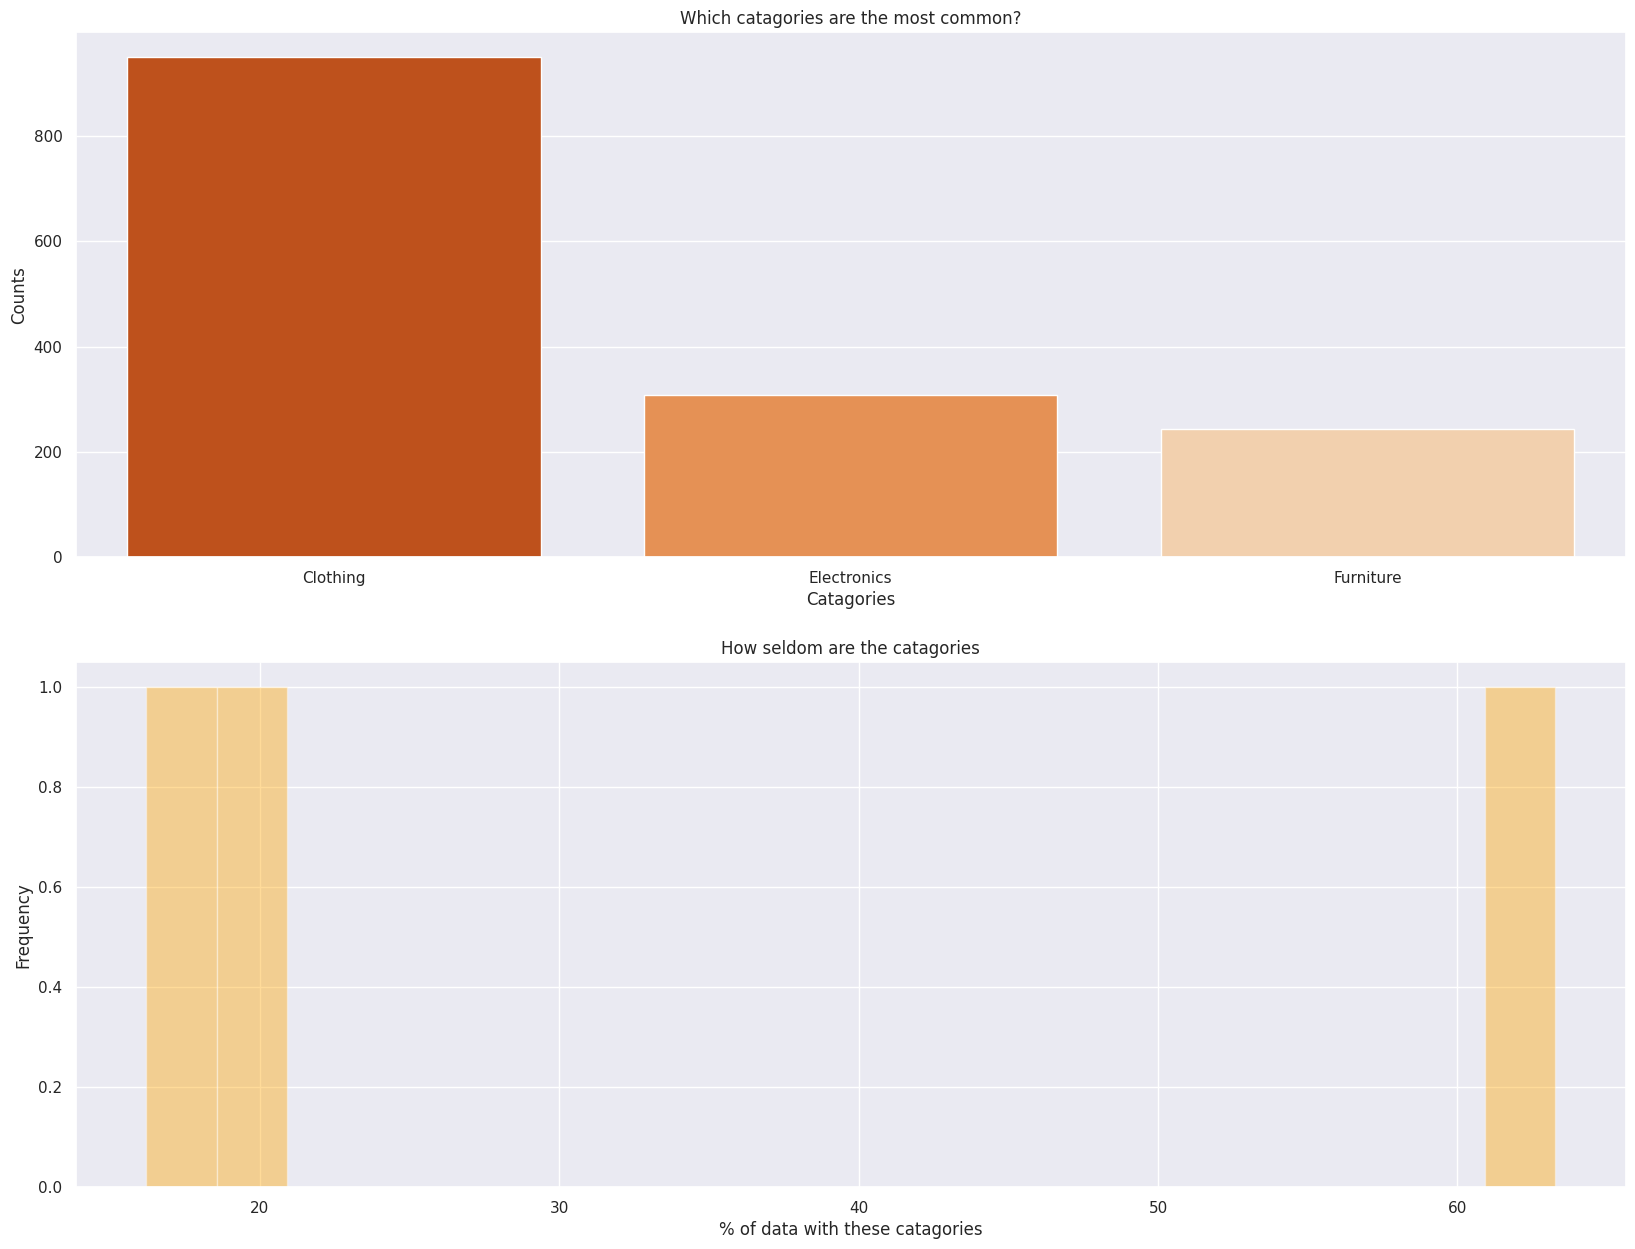

In [18]:
catagory_counts= order_sales['Category'].value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(x=catagory_counts.iloc[0:3].index,
            y=catagory_counts.iloc[0:3].values,
            ax = ax[0], palette='Oranges_r')
ax[0].set_ylabel("Counts")
ax[0].set_xlabel('Catagories')
ax[0].set_title("Which catagories are the most common?")
sns.distplot(np.round(catagory_counts/order_sales.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color='Orange')
ax[1].set_title("How seldom are the catagories")
ax[1].set_xlabel('% of data with these catagories')
ax[1].set_ylabel('Frequency')

This shows that the distribution is centered towards the 10-20% range, with a peak at around 60% where Clothing constitutes a good segment of the data.

### Common Sub-Categories

In [19]:
order_sales.rename(columns={'Sub-Category': 'Subcategory'}, inplace=True)
order_sales.Subcategory.nunique()

17

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'Saree'),
  Text(1, 0, 'Hankerchief'),
  Text(2, 0, 'Stole'),
  Text(3, 0, 'Phones'),
  Text(4, 0, 'Bookcases'),
  Text(5, 0, 'Electronic Games'),
  Text(6, 0, 'T-shirt'),
  Text(7, 0, 'Chairs'),
  Text(8, 0, 'Printers'),
  Text(9, 0, 'Furnishings'),
  Text(10, 0, 'Accessories'),
  Text(11, 0, 'Shirt'),
  Text(12, 0, 'Skirt'),
  Text(13, 0, 'Leggings'),
  Text(14, 0, 'Kurti'),
  Text(15, 0, 'Trousers'),
  Text(16, 0, 'Tables')])

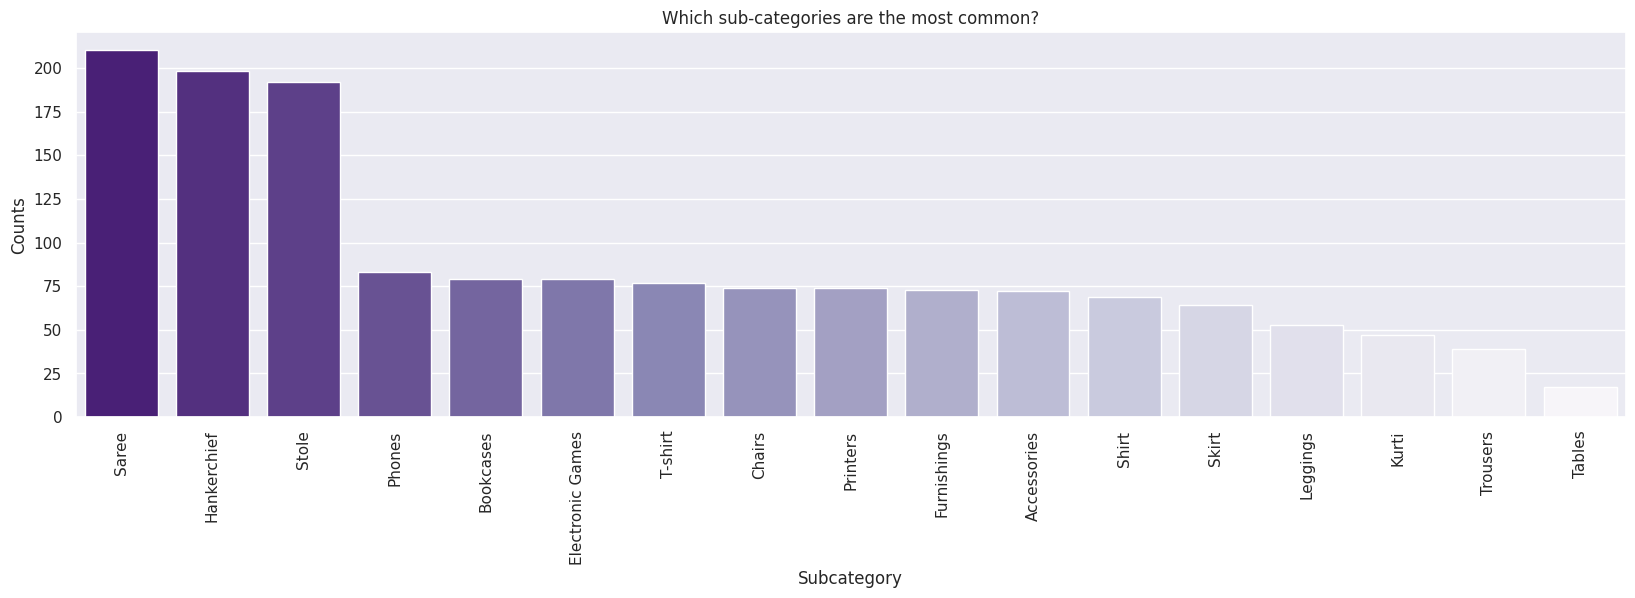

In [20]:
subcat_counts = order_sales.Subcategory.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(x=subcat_counts.index, y=subcat_counts.values, palette='Purples_r')
plt.ylabel('Counts')
plt.title('Which sub-categories are the most common?');
plt.xticks(rotation=90)

Now we can see that the categories do correspod to the product type. See the occurances of the Saree? Furthermore, the most common descriptions seem to confirm that the retailer sells various types of products.All descriptions seem to be capitalized normally. Ok, now lets do an additional analysis on the sub-cat by counting the length and the number of lowercase chars.

In [21]:
def count_lower_chars(l):
    return sum(1 for c in l if c.islower())

In [22]:
order_sales['SubcatLength'] = order_sales.Subcategory.apply(lambda l: len(l))
order_sales['LowChars'] = order_sales.Subcategory.apply(lambda l: count_lower_chars(l))

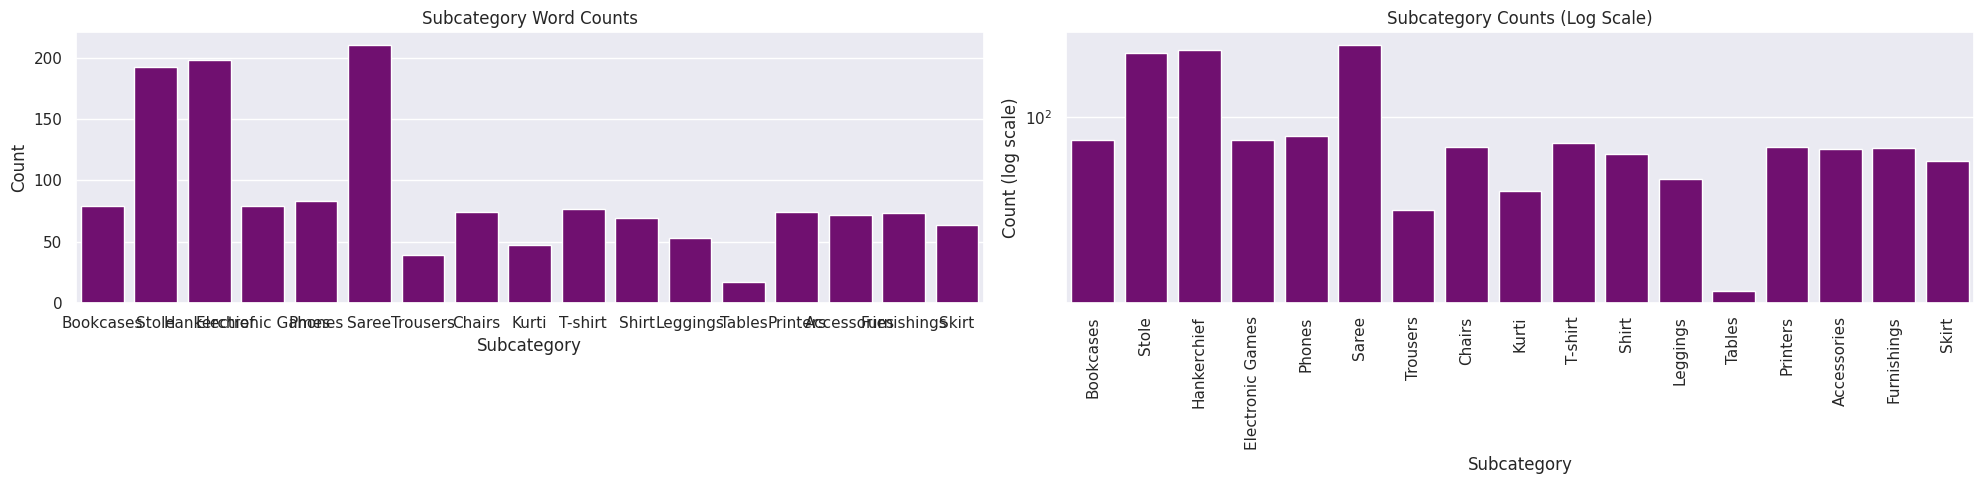

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.countplot(x='Subcategory', data=order_sales, ax=ax[0], color="Purple")

sns.countplot(x='Subcategory', data=order_sales, ax=ax[1], color="Purple")
ax[1].set_yscale("log")
ax[0].set_xlabel("Subcategory")
ax[0].set_ylabel("Count")
ax[0].set_title("Subcategory Word Counts")

ax[1].set_xlabel("Subcategory")
ax[1].set_ylabel("Count (log scale)")
ax[1].set_title("Subcategory Counts (Log Scale)")

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Descriptions seem completely normal to me!

Orders

In [24]:
demo.CustomerName.nunique()

332

Text(0.5, 1.0, 'Which Customer Names are most common')

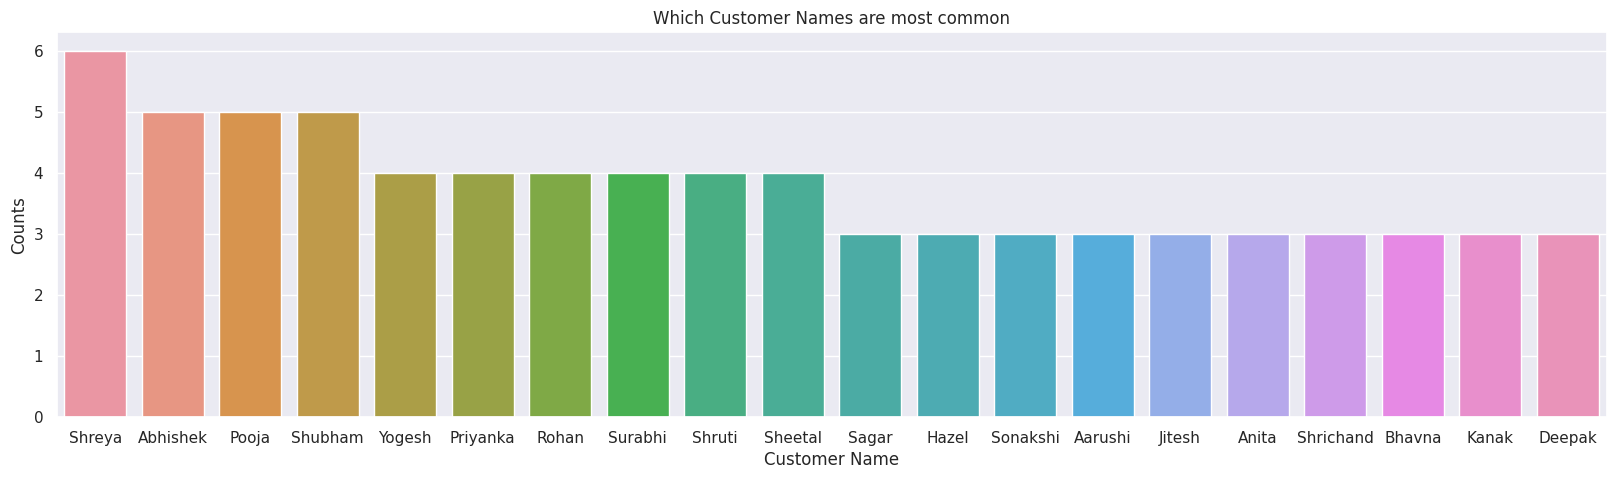

In [25]:
customer_counts = demo.CustomerName.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(x=customer_counts.index,y=customer_counts.values,order=customer_counts.index)
plt.ylabel('Counts')
plt.xlabel('Customer Name')
plt.title('Which Customer Names are most common')

State - What unique entries of states are there?

In [26]:
demo.State.nunique()

19

Let's graph out the popular states.

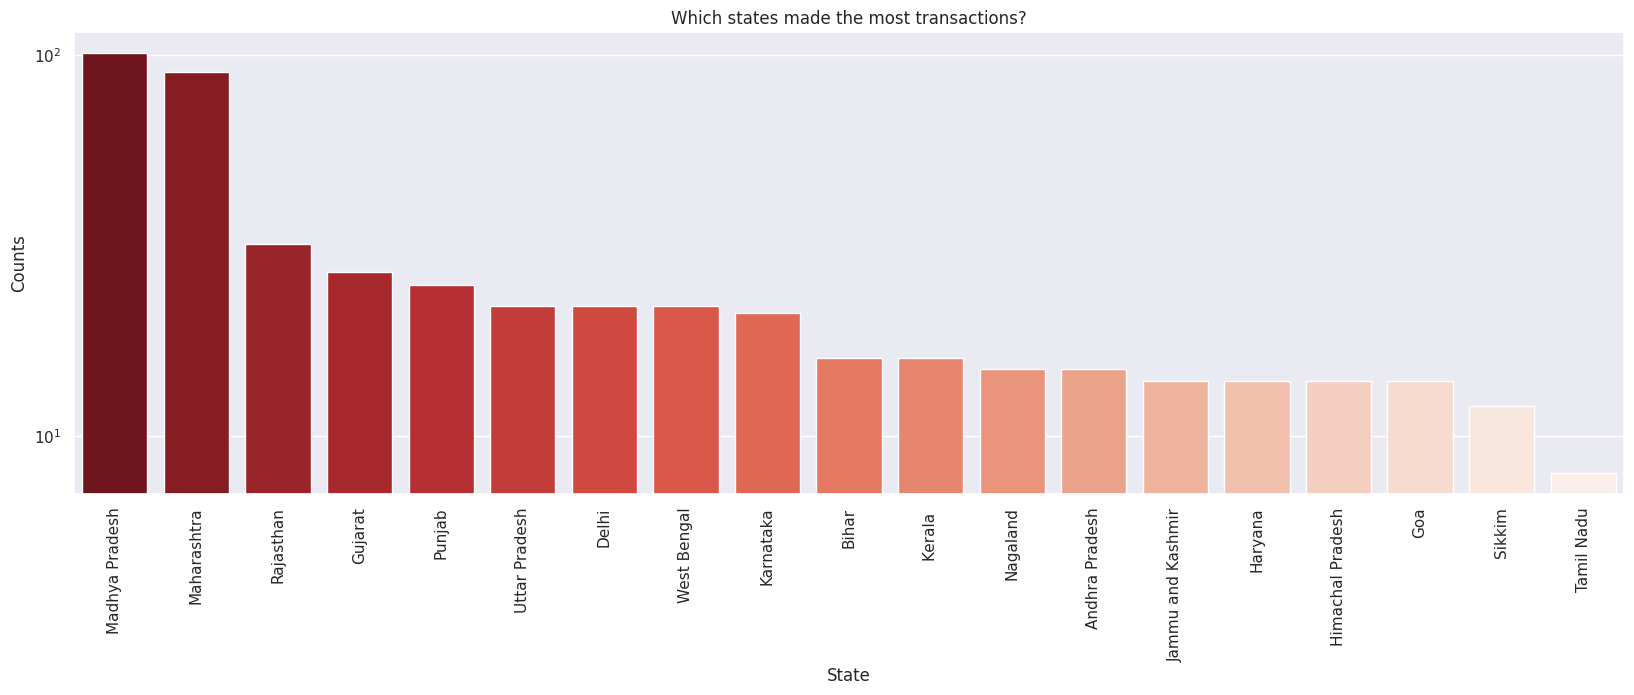

In [27]:
state_counts = demo.State.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,6))
sns.barplot(x=state_counts.index, y=state_counts.values, palette="Reds_r")
plt.ylabel("Counts")
plt.title("Which states made the most transactions?");
plt.xticks(rotation=90);
plt.yscale("log")

Cities
How many unique cities are delivered by the retailer?

In [28]:
demo.City.nunique()

24

And most common ones?

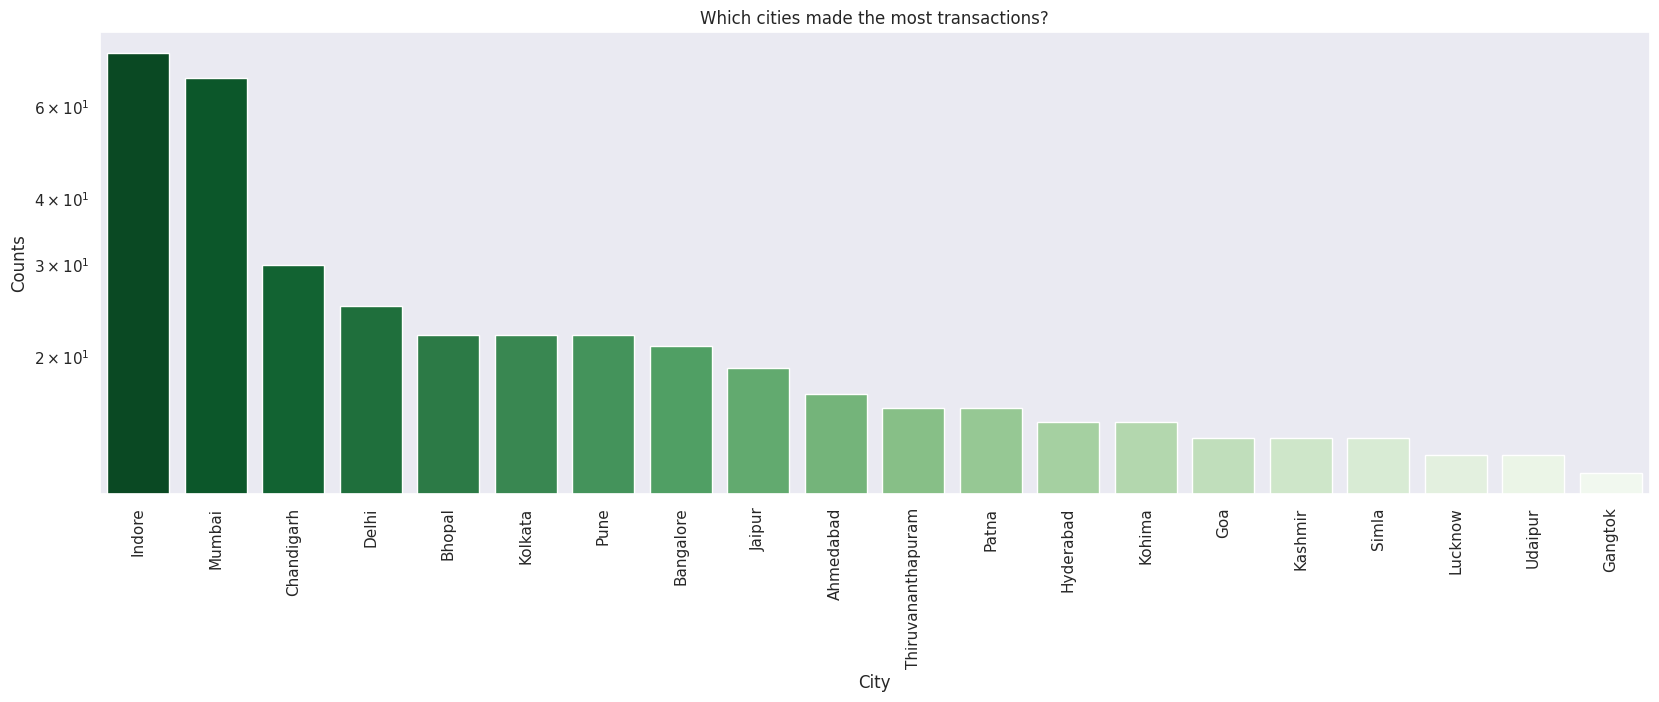

In [29]:
city_counts = demo.City.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,6))
sns.barplot(x=city_counts.index, y=city_counts.values, palette="Greens_r")
plt.ylabel("Counts")
plt.title("Which cities made the most transactions?");
plt.xticks(rotation=90);
plt.yscale("log")

Now we can see that the retailer sells the most product in Indore, followed by Mumbai and then the rest of the Indian cities. In addition, it seems like the cities follow the same pattern as the states. What percent of entries are inside Indore?

In [30]:
demo.loc[demo.City=="Indore"].shape[0] / demo.shape[0] * 100

13.571428571428571

Let's create a feature to indicate inside or outside of Indore.

In [31]:
demo['Inodre'] = np.where(demo.City == 'Indore', 1, 0)

Order Prices

Text(0, 0.5, 'Frequency')

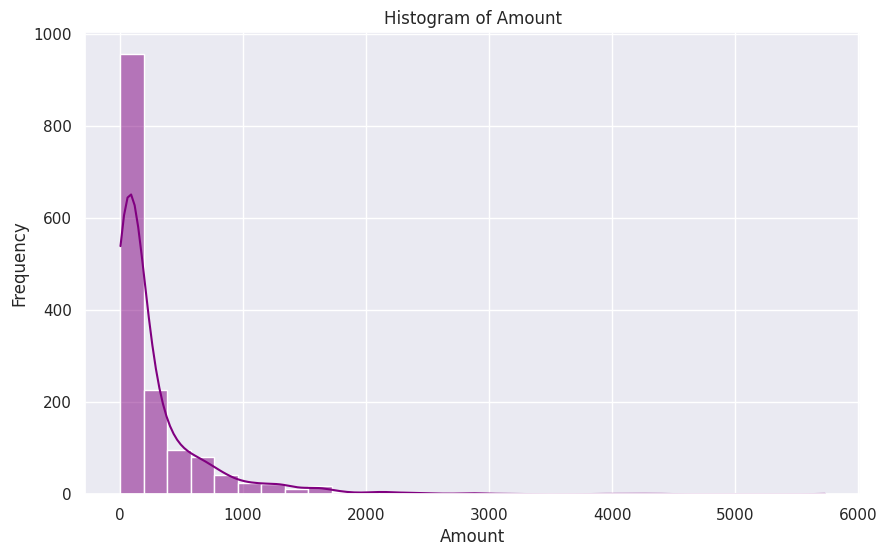

In [32]:
order_sales.Amount.describe()
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(order_sales.Amount, bins=30, kde=True, color='Purple')
plt.title('Histogram of Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')

Let's stick with transactions that fall into a range of prices, because we don't want to make predictions for products with ubsurdly high prices. Starting easy is always good!

In [33]:
order_sales = order_sales.loc[(order_sales.Amount > 4) & (order_sales.Amount < 450)].copy()

Quantities
Ok, so the most important one - the target> Let's look at the distribution.

In [34]:
order_sales.Quantity.describe()

count    1214.000000
mean        3.477759
std         2.027206
min         1.000000
25%         2.000000
50%         3.000000
75%         4.750000
max        14.000000
Name: Quantity, dtype: float64

Text(0, 0.5, 'Frequency')

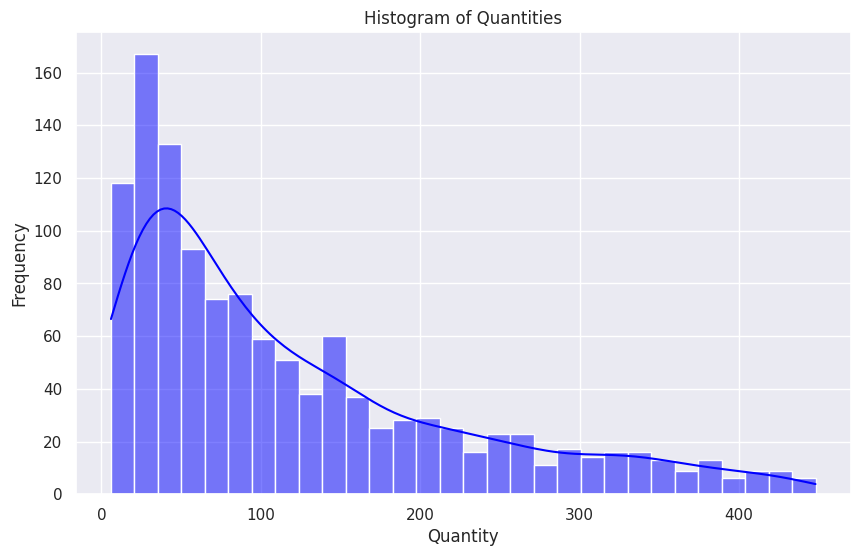

In [35]:
order_sales.Quantity.describe()
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(order_sales.Amount, bins=30, kde=True, color='Blue')
plt.title('Histogram of Quantities')
plt.xlabel('Quantity')
plt.ylabel('Frequency')

Ok, so the products are sold mostly in ranges 0-300 with a right skew. There are some extreme, unrealistic outliers again.

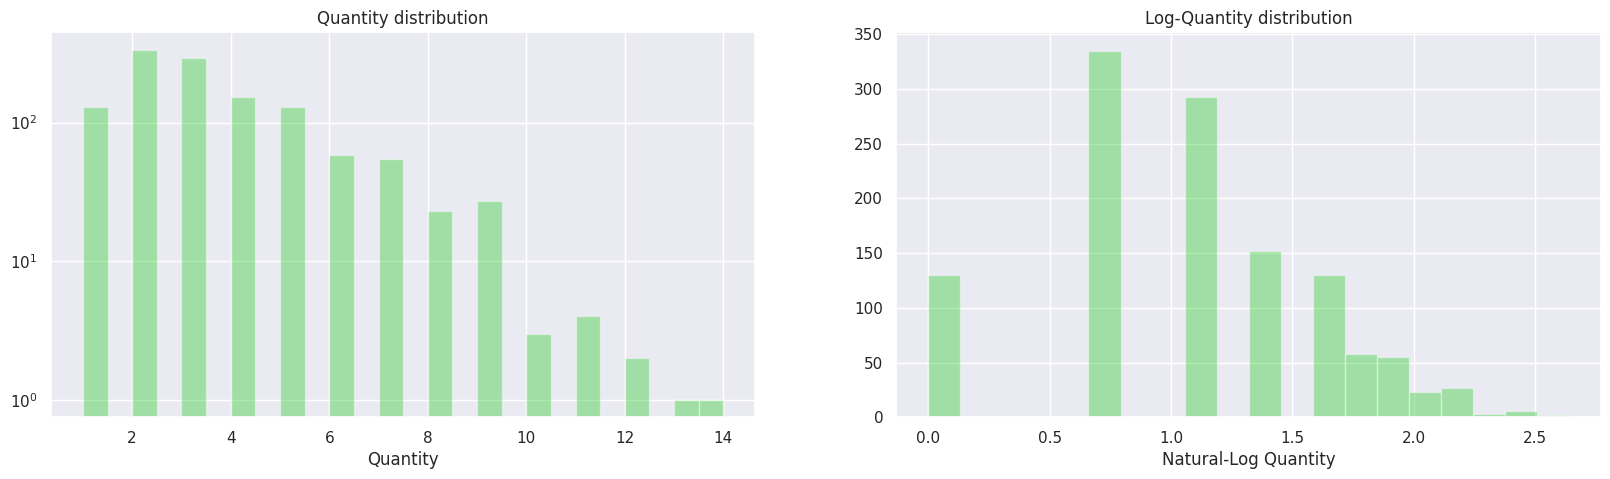

In [36]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(order_sales.Quantity, ax=ax[0], kde=False, color="limegreen");
sns.distplot(np.log(order_sales.Quantity), ax=ax[1], bins=20, kde=False, color="limegreen");
ax[0].set_title("Quantity distribution")
ax[0].set_yscale("log")
ax[1].set_title("Log-Quantity distribution")
ax[1].set_xlabel("Natural-Log Quantity");

From the log-transformed distribution, it would make sense to make a cut at:

In [37]:
np.quantile(order_sales.Quantity, 0.95)

7.349999999999909

In this case, we could still cover more than 95% of the data?

In [38]:
order_sales = order_sales.loc[order_sales.Quantity < 300].copy()

In [39]:
order_sales['Week'] = demo.OrderDate.dt.isocalendar().week
order_sales['OrderID'] = demo.OrderID

Revenues

Conclusion

## **Focus on daily product Sales**
As we would like to predict the daily amount of product sales, we need to compute the daily aggregation of this data. For this purpose, we need to extract temporal features from the invoiceDate. In addition, we can compute the revenue gained by a transaction and the unit prices and the quantity.

In [40]:
demo['Year'] = demo.OrderDate.dt.year
demo['Month'] = demo.OrderDate.dt.month
demo['Day'] = demo.OrderDate.dt.day
# Create a 'Week' column
demo['Week'] = demo.OrderDate.dt.isocalendar().week
demo["Date"] = pd.to_datetime(demo[['Year', 'Month', 'Day']])

In [41]:
grouped_features = ['Date', 'Year', 'Month', 'Day', 'Week']

This way, we lose info about customers, countries, and price, but we will recover it later in this kernel. Besides the quantities, lets bring in the revenue.

In [42]:
daily_data = demo.groupby(grouped_features).size().reset_index(name='counts')
daily_data['Amount'] = order_sales.Amount
daily_data['Profit'] = order_sales.Profit
daily_data['Quantity'] = order_sales.Quantity
daily_data.head()

,Date,Year,Month,Day,Week,counts,Amount,Profit,Quantity
0,2018-04-01,2018.0,4.0,1.0,13,2,NaN,NaN,NaN
1,2018-04-03,2018.0,4.0,3.0,14,2,66.0,-12.0,5.0
2,2018-04-05,2018.0,4.0,5.0,14,1,8.0,-2.0,3.0
3,2018-04-06,2018.0,4.0,6.0,14,2,80.0,-56.0,4.0
4,2018-04-08,2018.0,4.0,8.0,14,1,168.0,-111.0,2.0


How are the quantities and profits distributed?¶

(1.0, 10.060000000000002)
(-294.61, 126.53)


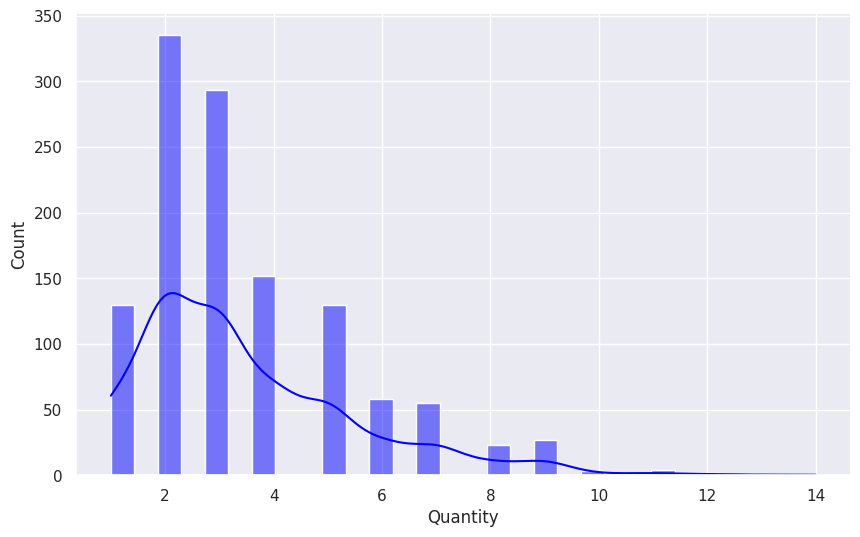

In [43]:
daily_data.loc[:, ['Quantity', 'Profit']].describe()
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(order_sales.Quantity, bins=30, kde=True, color='Blue')
low_quantity = daily_data.Quantity.quantile(0.01)
high_quantity = daily_data.Quantity.quantile(0.99)
print((low_quantity, high_quantity))
low_profit = daily_data.Profit.quantile(0.01)
high_profit = daily_data.Profit.quantile(0.99)
print((low_profit, high_profit))

As we can see by the data, the data is evenly distributed, therefore there should be nothing that will mislead our validation. Hwover, just to keep things within a solid range, early stopping will be beneficial.

Let's keep using target ranges of data that are occupied by 90% of the data entries/ THis is a first and easy strategy to exclude heavy outliers,but we should always be aware that we have lost some information. 

In [44]:
samples = daily_data.shape[0]
daily_data = daily_data.loc[
    (daily_data.Quantity >= low_quantity) & (daily_data.Quantity <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.Profit >= low_profit) & (daily_data.Profit <= high_profit)]

How many entries did we lose?

In [45]:
samples - daily_data.shape[0]

68

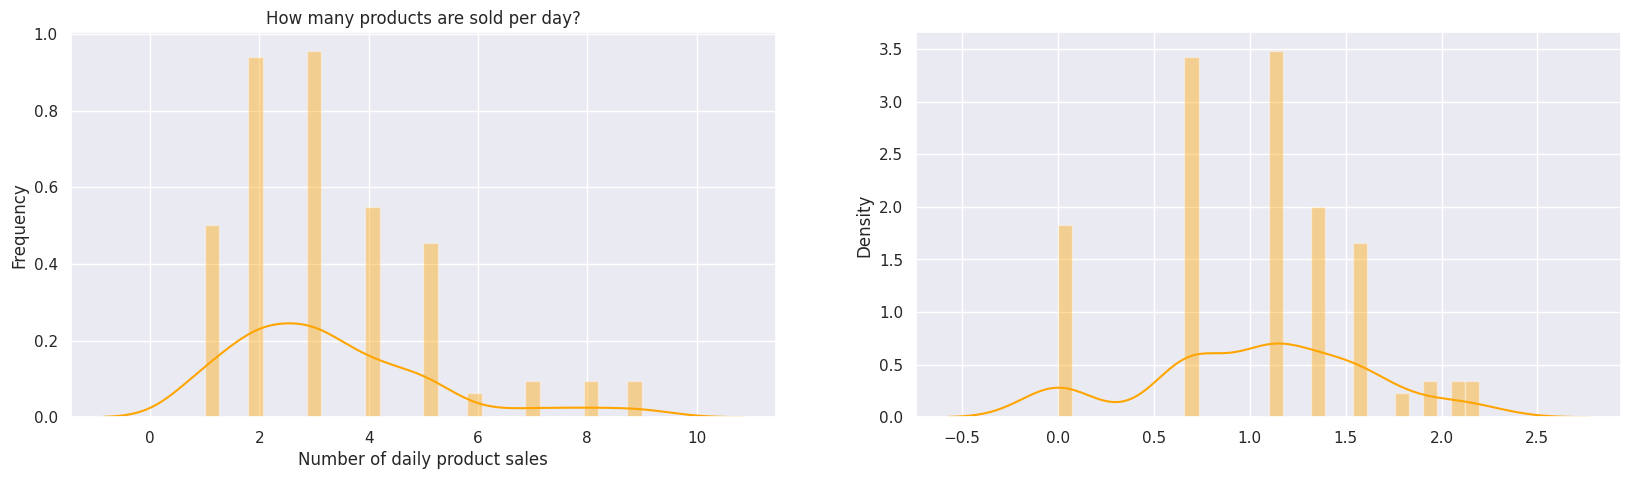

In [46]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(daily_data.Quantity.values, kde=True, ax=ax[0], color="Orange", bins=30);
sns.distplot(np.log(daily_data.Quantity.values), kde=True, ax=ax[1], color="Orange", bins=30);
ax[0].set_xlabel("Number of daily product sales");
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many products are sold per day?");

We can see that the distributions are **right skewed**. Lower values are therefrore more common. IN addition, it's usual for quantities to be bought in a bunch rather than single quantities.

## Predicting Daily Product Sales?
Here, I'll attempt at the catboost as the predictive model and regressor. As for the metric,I will be using root mean square error.


The Root Mean Squared Error (RMSE) measures how far off your predictions are from the actual values, but it's very sensitive to outliers. This means that even a few big mistakes can make your RMSE look bad, even if most of your predictions are good.

## Validation Strategy
Due to the data only covering a year, we need to select validation data carefully. Lets start with covering at least 8 weeks. After generatign new features, I will use sliding time series validation to udnerstand if the model is able to solve the prediction task both times.

## Hyperparameter Class
Loss function, evaluation metric, max depth of trees, number of max trees, l2_leaf_reg for overfitting.

In [47]:
class CatHyperparameter:
    
    def __init__(self,
                 loss="RMSE",
                 metric="RMSE",
                 iterations=1000,
                 max_depth=4,
                 l2_leaf_reg=3,
                 #learning_rate=0.5,
                 seed=0):
        self.loss = loss,
        self.metric = metric,
        self.max_depth = max_depth,
        self.l2_leaf_reg = l2_leaf_reg,
        #self.learning_rate = learning_rate,
        self.iterations=iterations
        self.seed = seed

In [48]:
from catboost import CatBoostRegressor, Pool

class Catmodel:
    
    def __init__(self, name, params):
        self.name = name
        self.params = params
    
    def set_data_pool(self, train_pool, val_pool):
        self.train_pool = train_pool
        self.val_pool = val_pool
    
    def set_data(self, X, y, week):
        cat_features_idx = np.where(X.dtypes != np.float64)[0]
        x_train, self.x_val = X.loc[X.Week < week], X.loc[X.Week >= week]
        y_train, self.y_val = y.loc[X.Week < week], y.loc[X.Week >= week]
        self.train_pool = Pool(data=x_train, label=y_train, cat_features=cat_features_idx)
        self.val_pool = Pool(data=self.x_val, label=self.y_val, cat_features=cat_features_idx)
        
    def prepare_model(self):
        self.model = CatBoostRegressor(
                loss_function = self.params.loss[0],
                random_seed = self.params.seed,
                logging_level = 'Silent',
                iterations = self.params.iterations,
                max_depth = self.params.max_depth[0],
                #learning_rate = self.params.learning_rate[0],
                l2_leaf_reg = self.params.l2_leaf_reg[0],
                od_type='Iter',
                od_wait=40,
                train_dir=self.name,
                has_time=True
            )
    
    def learn(self, plot=False):
        self.prepare_model()
        self.model.fit(self.train_pool, eval_set=self.val_pool, plot=plot)
        print("{}, early-stopped model tree count {}".format(
            self.name, self.model.tree_count_
        ))
    
    def score(self):
        return self.model.score(self.val_pool)
    
    def show_importances(self, kind="bar"):
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.val_pool)
        if kind=="bar":
            return shap.summary_plot(shap_values, self.x_val, plot_type="bar")
        return shap.summary_plot(shap_values, self.x_val)
    
    def get_val_results(self):
        self.results = pd.DataFrame(self.y_val)
        self.results["prediction"] = self.predict(self.x_val)
        self.results["error"] = np.abs(
            self.results[self.results.columns.values[0]].values - self.results.prediction)
        self.results["Month"] = self.x_val.Month
        self.results["SquaredError"] = self.results.error.apply(lambda l: np.power(l, 2))
    
    def show_val_results(self):
        self.get_val_results()
        fig, ax = plt.subplots(1,2,figsize=(20,5))
        sns.distplot(self.results.error, ax=ax[0])
        ax[0].set_xlabel("Single absolute error")
        ax[0].set_ylabel("Density")
        self.median_absolute_error = np.median(self.results.error)
        print("Median absolute error: {}".format(self.median_absolute_error))
        ax[0].axvline(self.median_absolute_error, c="black")
        ax[1].scatter(self.results.prediction.values,
                      self.results[self.results.columns[0]].values,
                      c=self.results.error, cmap="RdYlBu_r", s=1)
        ax[1].set_xlabel("Prediction")
        ax[1].set_ylabel("Target")
        return ax
    
    def get_monthly_RMSE(self):
        return self.results.groupby("Month").SquaredError.mean().apply(lambda l: np.sqrt(l))
        
    def predict(self, x):
        return self.model.predict(x)
    
    def get_dependence_plot(self, feature1, feature2=None):
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.val_pool)
        if feature2 is None:
            return shap.dependence_plot(
                feature1,
                shap_values,
                self.x_val,
            )
        else:
            return shap.dependence_plot(
                feature1,
                shap_values,
                self.x_val,
                interaction_index=feature2
            )
    

In [49]:

class Hypertuner:
    
    def __init__(self, model, max_iter=10, max_time=10,max_depth=6, max_l2_leaf_reg=20):
        self.bounds = [{'name': 'depth','type': 'discrete','domain': (1,max_depth)},
                       {'name': 'l2_leaf_reg','type': 'discrete','domain': (1,max_l2_leaf_reg)}]
        self.model = model
        self.max_iter=max_iter
        self.max_time=max_time
        self.best_depth = None
        self.best_l2_leaf_reg = None
    
    def objective(self, params):
        params = params[0]
        params = CatHyperparameter(
            max_depth=params[0],
            l2_leaf_reg=params[1]
        )
        self.model.params = params
        self.model.learn()
        return self.model.score()
    
    def learn(self):
        np.random.seed(777)
        optimizer = GPyOpt.methods.BayesianOptimization(
            f=self.objective, domain=self.bounds,
            acquisition_type ='EI',
            acquisition_par = 0.2,
            exact_eval=True)
        optimizer.run_optimization(self.max_iter, self.max_time)
        optimizer.plot_convergence()
        best = optimizer.X[np.argmin(optimizer.Y)]
        self.best_depth = best[0]
        self.best_l2_leaf_reg = best[1]
        print("Optimal depth is {} and optimal l2-leaf-reg is {}".format(self.best_depth, self.best_l2_leaf_reg))
        print('Optimal RMSE:', np.min(optimizer.Y))
    
    def retrain_catmodel(self):
        params = CatHyperparameter(
            max_depth=self.best_depth,
            l2_leaf_reg=self.best_l2_leaf_reg
        )
        self.model.params = params
        self.model.learn(plot=True)
        return self.model

In [50]:
class CatFamily:
    
    def __init__(self, params, X, y, n_splits=2):
        self.family = {}
        self.cat_features_idx = np.where(X.dtypes != np.float)[0]
        self.X = X.values
        self.y = y.values
        self.n_splits = n_splits
        self.params = params
    
    def set_validation_strategy(self):
        self.cv = TimeSeriesSplit(max_train_size = None,
                                  n_splits = self.n_splits)
        self.gen = self.cv.split(self.X)
    
    def get_split(self):
        train_idx, val_idx = next(self.gen)
        x_train, x_val = self.X[train_idx], self.X[val_idx]
        y_train, y_val = self.y[train_idx], self.y[val_idx]
        train_pool = Pool(x_train, y_train, cat_features=self.cat_features_idx)
        val_pool = Pool(x_val, y_val, cat_features=self.cat_features_idx)
        return train_pool, val_pool
    
    def learn(self):
        self.set_validation_strategy()
        self.model_names = []
        self.model_scores = []
        for split in range(self.n_splits):
            name = 'Model_cv_' + str(split) + '/'
            train_pool, val_pool = self.get_split()
            self.model_names.append(name)
            self.family[name], score = self.fit_catmodel(name, train_pool, val_pool)
            self.model_scores.append(score)
    
    def fit_catmodel(self, name, train_pool, val_pool):
        cat = Catmodel(name, train_pool, val_pool, self.params)
        cat.prepare_model()
        cat.learn()
        score = cat.score()
        return cat, score
    
    def score(self):
        return np.mean(self.model_scores)
    
    def show_learning(self):
        widget = MetricVisualizer(self.model_names)
        widget.start()

    def show_importances(self):
        name = self.model_names[-1]
        cat = self.family[name]
        explainer = shap.TreeExplainer(cat.model)
        shap_values = explainer.shap_values(cat.val_pool)
        return shap.summary_plot(shap_values, X, plot_type="bar")

In [51]:
daily_data.head()

,Date,Year,Month,Day,Week,counts,Amount,Profit,Quantity
1,2018-04-03,2018.0,4.0,3.0,14,2,66.0,-12.0,5.0
2,2018-04-05,2018.0,4.0,5.0,14,1,8.0,-2.0,3.0
3,2018-04-06,2018.0,4.0,6.0,14,2,80.0,-56.0,4.0
4,2018-04-08,2018.0,4.0,8.0,14,1,168.0,-111.0,2.0
5,2018-04-09,2018.0,4.0,9.0,15,2,424.0,-272.0,5.0


In [52]:
week = daily_data.Week.max() - 2
print("Validation after week {}".format(week))
print("Validation starts at timepoint {}".format(
    daily_data[daily_data.Week==week].Date.min()
))

Validation after week 50
Validation starts at timepoint 2018-12-10 00:00:00


In [53]:
!pip install catboost


In [54]:
X = daily_data.drop(["Quantity", "Profit", "Date"], axis=1)
daily_data.Quantity = np.log(daily_data.Quantity)
y = daily_data.Quantity
params = CatHyperparameter()

model = Catmodel("baseline", params)
model.set_data(X,y, week)
model.learn(plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

baseline, early-stopped model tree count 58


In [55]:
model.score()

0.09298064242469073

Median absolute error: 0.4834119137660773


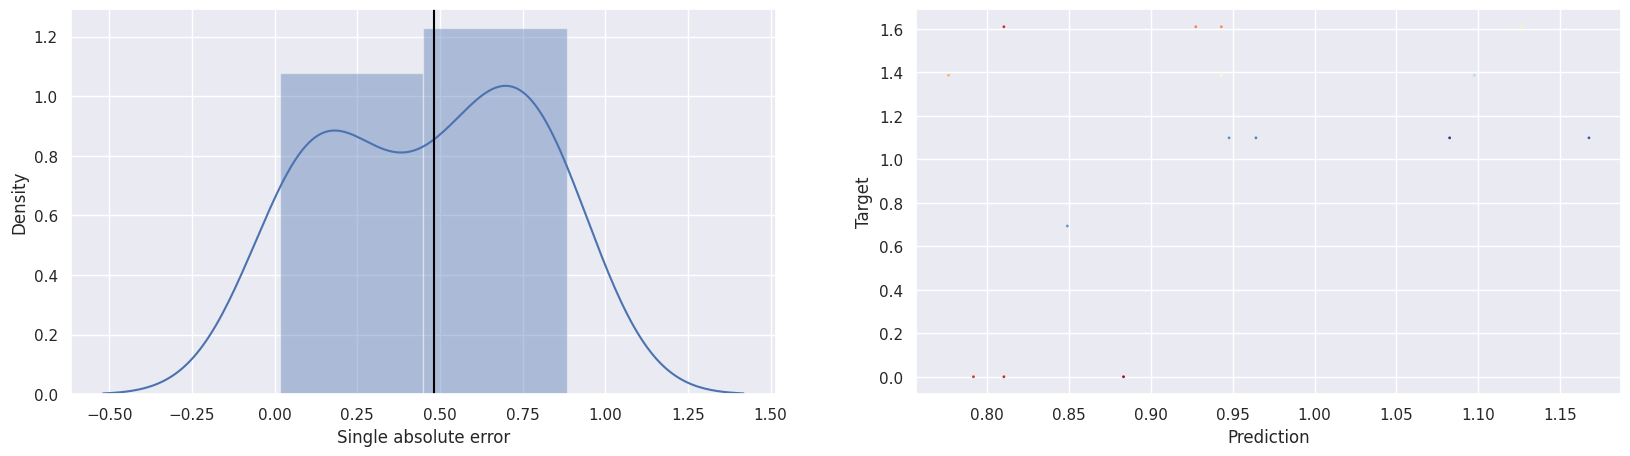

In [56]:
model.show_val_results();

These values show wonderful results.
- We can see that the distribution of absolute values is evenly distributed.

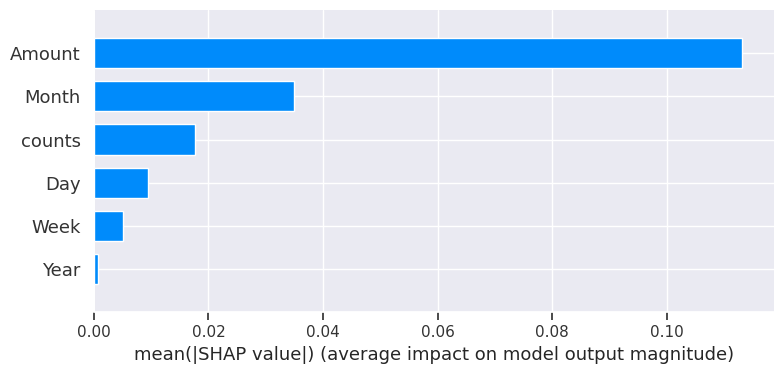

In [57]:
model.show_importances()

- Here, we can see that the Amount as well ast the Month were very important. 
- The **month** is a very important feature as seen by exploring the data. Low values from monday up to thursday are those days where the retailer sales most products. In contrast, high values only yield a few sales.

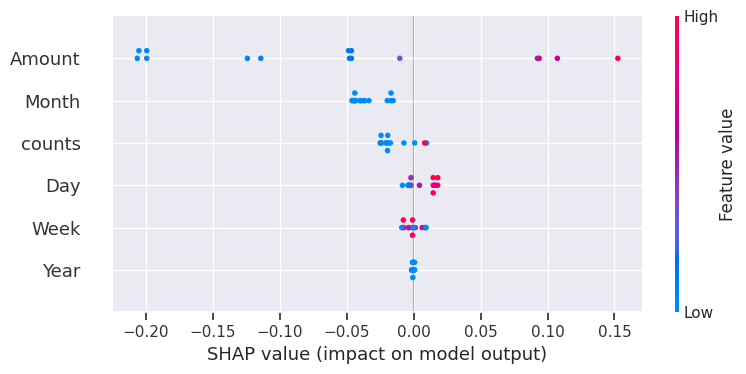

In [58]:
model.show_importances(kind=None)

In [59]:
np.mean(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

1.2737217255947197

In [60]:
np.median(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

1.2481082097053235

## Bayesian Hyperparameter Search with GPyOpt
Now that we understand what it's like with a single model, lets figure out if it would be better with a hyperparameter search.

In [61]:
order_sales['DescriptionLength'] = order_sales['Category'].apply(len)
products = pd.DataFrame(index=order_sales.loc[order_sales.Week < week].OrderID.unique(), columns=["MedianPrice"])
products["MedianPrice"] = order_sales.loc[order_sales.Week < week].groupby("OrderID").Amount.median()
products["MedianQuantities"] = order_sales.loc[order_sales.Week < week].groupby("OrderID").Quantity.median()
products["Customers"] = order_sales.loc[order_sales.Week < week].groupby("OrderID").OrderID.nunique()
products["DescriptionLength"] = order_sales.loc[order_sales.Week < week].groupby("OrderID").DescriptionLength.median()


# products["StockCode"] = products.index.values


org_cols = np.copy(products.columns.values)

# Display the first few rows of the DataFrame
products.head()


,MedianPrice,MedianQuantities,Customers,DescriptionLength
B-25602,66.0,5.0,1,8.0
B-25603,8.0,3.0,1,8.0
B-25604,80.0,4.0,1,11.0
B-25605,168.0,2.0,1,11.0
B-25606,424.0,5.0,1,11.0


Text(0, 0.5, 'Boxcox-Median-Quantities')

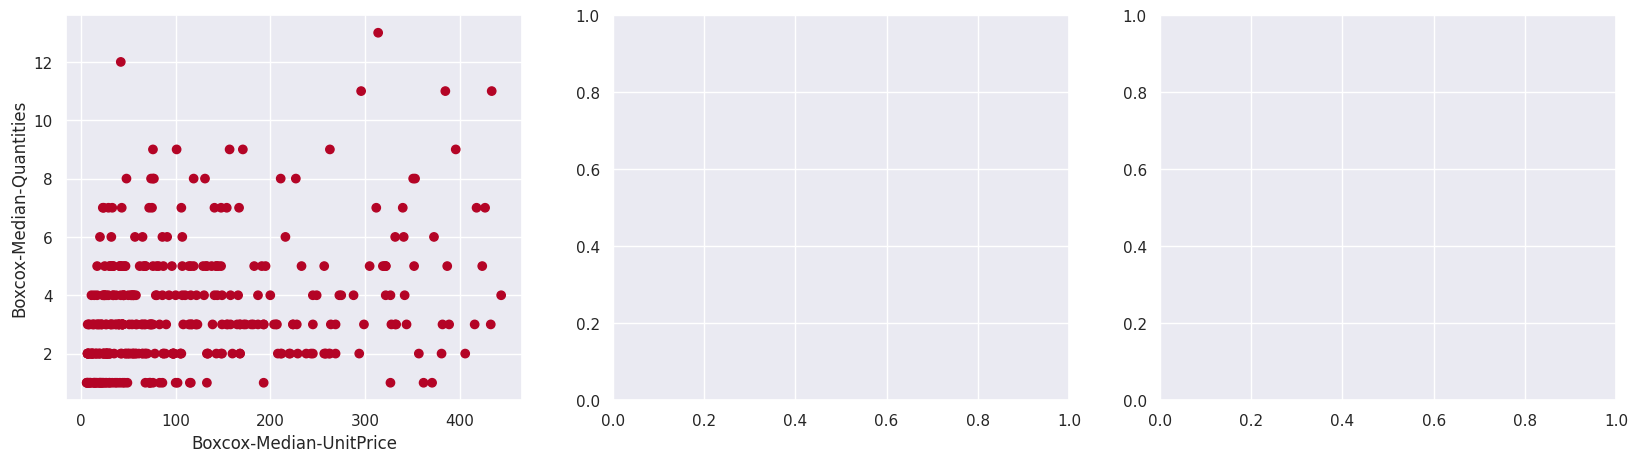

In [62]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].scatter(products.MedianPrice.values, products.MedianQuantities.values,
           c=products.Customers.values, cmap="coolwarm_r")
ax[0].set_xlabel("Boxcox-Median-UnitPrice")
ax[0].set_ylabel("Boxcox-Median-Quantities")

In [63]:

order_sales.loc[order_sales.OrderID.isnull()==False, "lowercase_names"] = order_sales.loc[
    order_sales.OrderID.isnull()==False, 'OrderID'
].apply(lambda l: l.lower())

demo.lowercase_names.dropna().apply(
lambda l: np.where("nan" in l,True, False)).value_counts()

lowercase_names
False    496
True       4
Name: count, dtype: int64

In [64]:
daily_data['OrderID'] = order_sales['OrderID']
daily_data['Category'] = order_sales['Category']
demo['Amount'] = order_sales['Amount']

In [65]:
X = products.values
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [66]:
km = KMeans(n_clusters=30)
products["cluster"] = km.fit_predict(X)

daily_data.Category = daily_data.Category.astype("object")
daily_data.head()

,Date,Year,Month,Day,Week,counts,Amount,Profit,Quantity,OrderID,Category
1,2018-04-03,2018.0,4.0,3.0,14,2,66.0,-12.0,1.609438,B-25602,Clothing
2,2018-04-05,2018.0,4.0,5.0,14,1,8.0,-2.0,1.098612,B-25603,Clothing
3,2018-04-06,2018.0,4.0,6.0,14,2,80.0,-56.0,1.386294,B-25604,Electronics
4,2018-04-08,2018.0,4.0,8.0,14,1,168.0,-111.0,0.693147,B-25605,Electronics
5,2018-04-09,2018.0,4.0,9.0,15,2,424.0,-272.0,1.609438,B-25606,Electronics


In [67]:
known_price_iqr = order_sales.groupby("OrderID").Amount.quantile(0.75) 
known_price_iqr -= order_sales.groupby("OrderID").Amount.quantile(0.25) 
daily_data.head()

,Date,Year,Month,Day,Week,counts,Amount,Profit,Quantity,OrderID,Category
1,2018-04-03,2018.0,4.0,3.0,14,2,66.0,-12.0,1.609438,B-25602,Clothing
2,2018-04-05,2018.0,4.0,5.0,14,1,8.0,-2.0,1.098612,B-25603,Clothing
3,2018-04-06,2018.0,4.0,6.0,14,2,80.0,-56.0,1.386294,B-25604,Electronics
4,2018-04-08,2018.0,4.0,8.0,14,1,168.0,-111.0,0.693147,B-25605,Electronics
5,2018-04-09,2018.0,4.0,9.0,15,2,424.0,-272.0,1.609438,B-25606,Electronics


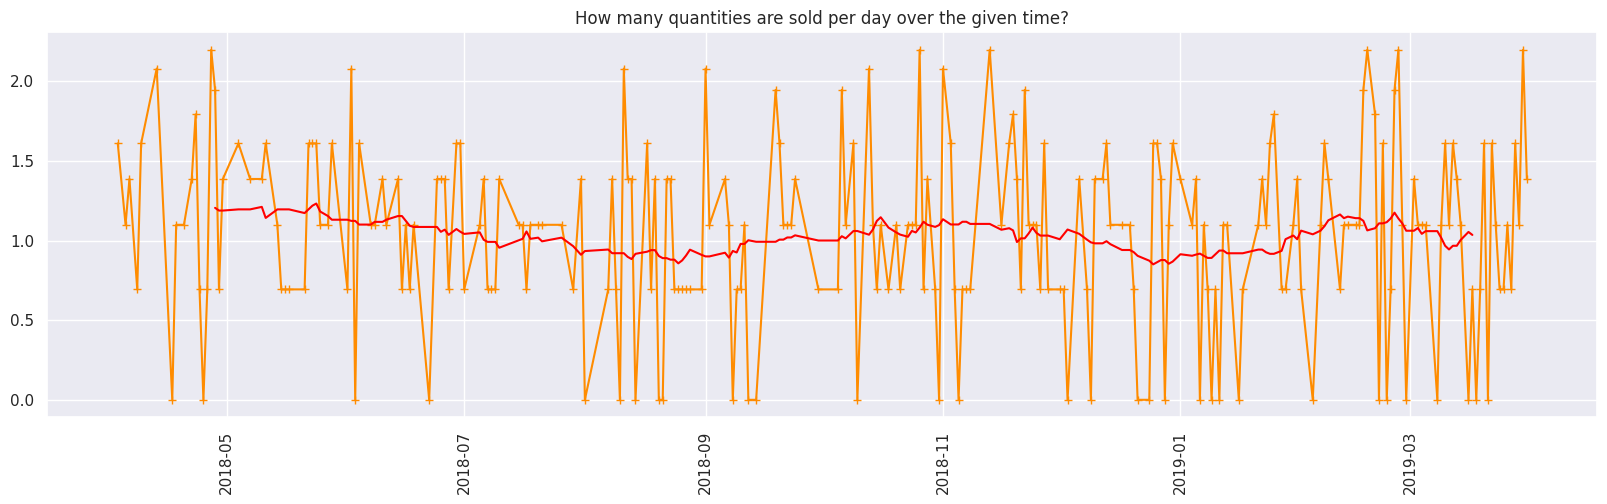

In [68]:

plt.figure(figsize=(20,5))
plt.plot(daily_data.groupby("Date").Quantity.sum(), marker='+', c="darkorange")
plt.plot(daily_data.groupby("Date").Quantity.sum().rolling(window=30, center=True).mean(),
        c="red")
plt.xticks(rotation=90);
plt.title("How many quantities are sold per day over the given time?");

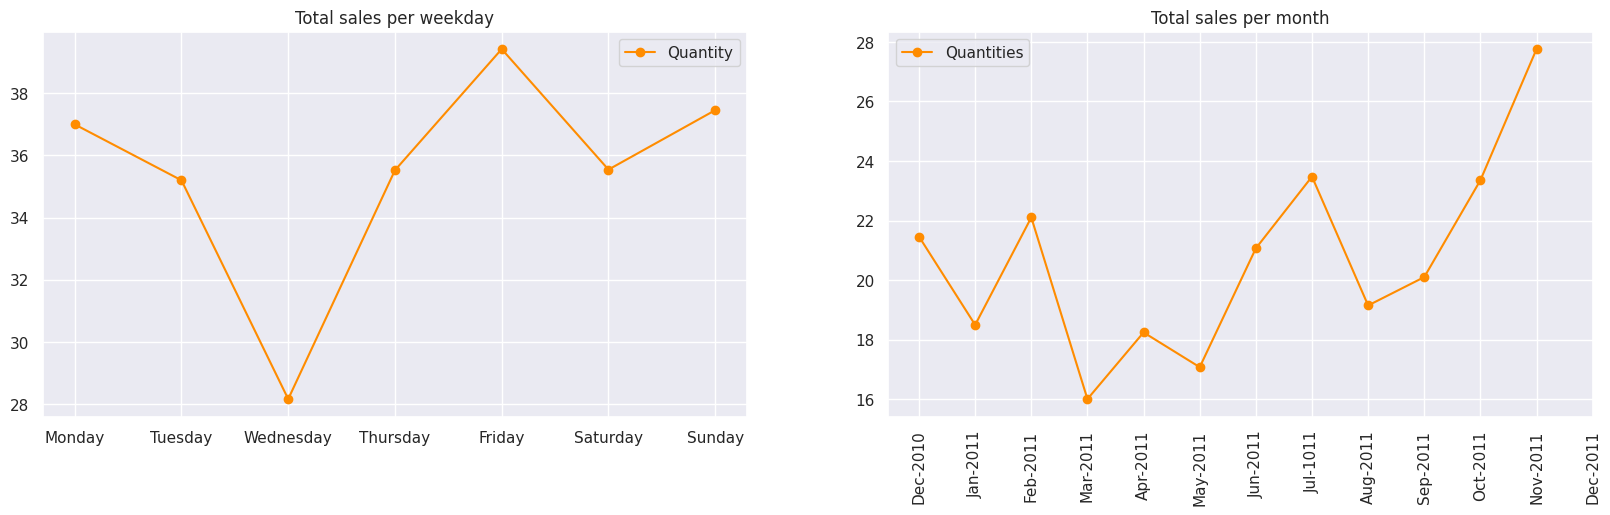

In [69]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
daily_data['Weekday'] = daily_data['Date'].dt.weekday
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
yearmonth = ["Dec-2010", "Jan-2011", "Feb-2011", "Mar-2011", "Apr-2011", "May-2011",
             "Jun-2011", "Jul-1011", "Aug-2011", "Sep-2011", "Oct-2011", "Nov-2011", 
             "Dec-2011"]

daily_data.groupby("Weekday").Quantity.sum().plot(
    ax=ax[0], marker='o', label="Quantity", c="darkorange");
ax[0].legend();
ax[0].set_xticks(np.arange(0,7))
ax[0].set_xticklabels(weekdays);
ax[0].set_xlabel("")
ax[0].set_title("Total sales per weekday");

ax[1].plot(daily_data.groupby(["Year", "Month"]).Quantity.sum().values,
    marker='o', label="Quantities", c="darkorange");
ax[1].set_xticklabels(yearmonth, rotation=90)
ax[1].set_xticks(np.arange(0, len(yearmonth)))
ax[1].legend();
ax[1].set_title("Total sales per month");

According to the insights above:
- Friday seems to be the day when most products are sold,
- In contrast, Wednesday seems to have very ****low transactions. 
- The pre-chirstmas season begins in september and shows a peak in **November**.
- The month of March and May additionally show very low sales.


## Lag-Features:

In [70]:
for delta in range(1,4):
    to_group = ["Week","Weekday","Category"]
    daily_data = daily_data.set_index(to_group)
        
    daily_data["QuantityProducttypeWeekWeekdayLag_" + str(delta) + "_median"] = daily_data.groupby(
        to_group).Quantity.median().apply(lambda l: np.round(l,1)).shift(delta)
    
    daily_data = daily_data.reset_index()
    daily_data.loc[daily_data.Week >= (week+delta),
                   "QuantityProductTypeWeekWeekdayLag_" + str(delta) + "_median"] = np.nan

In [71]:
order_sales["Category"] = order_sales.Category.map(products.cluster)

In [72]:
daily_data["TransactionsPerCategory"] = daily_data.Category.map(daily_data.loc[daily_data.Week < week].groupby("Category").OrderID.nunique())

About Cities and Customers

In [73]:
delta = 1
order_sales['Weekday'] = demo['Date'].dt.weekday
to_group = ["Week", "Weekday", "Category"]
daily_data = daily_data.set_index(to_group)
daily_data["DummyWeekWeekdayAttraction"] = order_sales.groupby(to_group).OrderID.nunique()
daily_data["DummyWeekWeekdayMeanUnitPrice"] = order_sales.groupby(to_group).Amount.mean().apply(lambda l: np.round(l, 2))

daily_data["WeekWeekdayAttraction_Lag1"] = daily_data["DummyWeekWeekdayAttraction"].shift(1)
daily_data["WeekWeekdayMeanUnitPrice_Lag1"] = daily_data["DummyWeekWeekdayMeanUnitPrice"].shift(1)

daily_data = daily_data.reset_index()
daily_data.loc[daily_data.Week >= (week + delta), "WeekWeekdayAttraction_Lag1"] = np.nan
daily_data.loc[daily_data.Week >= (week + delta), "WeekWeekdayMeanUnitPrice_Lag1"] = np.nan
daily_data = daily_data.drop(["DummyWeekWeekdayAttraction", "DummyWeekWeekdayMeanUnitPrice"], axis=1)

In [74]:
daily_data["TransactionsPerOrderID"] = daily_data.OrderID.map(
    demo.loc[demo.Week < week].groupby("OrderID").OrderID.nunique())

In [75]:
daily_data.head()

,Week,Weekday,Category,Date,Year,Month,Day,counts,Amount,Profit,...,QuantityProducttypeWeekWeekdayLag_1_median,QuantityProductTypeWeekWeekdayLag_1_median,QuantityProducttypeWeekWeekdayLag_2_median,QuantityProductTypeWeekWeekdayLag_2_median,QuantityProducttypeWeekWeekdayLag_3_median,QuantityProductTypeWeekWeekdayLag_3_median,TransactionsPerCategory,WeekWeekdayAttraction_Lag1,WeekWeekdayMeanUnitPrice_Lag1,TransactionsPerOrderID
0,14,1,Clothing,2018-04-03,2018.0,4.0,3.0,2,66.0,-12.0,...,1.4,NaN,2.2,NaN,1.1,NaN,150,NaN,NaN,1.0
1,14,3,Clothing,2018-04-05,2018.0,4.0,5.0,1,8.0,-2.0,...,1.6,NaN,1.4,NaN,2.2,NaN,150,NaN,NaN,1.0
2,14,4,Electronics,2018-04-06,2018.0,4.0,6.0,2,80.0,-56.0,...,1.1,NaN,1.6,NaN,1.4,NaN,46,NaN,NaN,1.0
3,14,6,Electronics,2018-04-08,2018.0,4.0,8.0,1,168.0,-111.0,...,1.4,NaN,1.1,NaN,1.6,NaN,46,NaN,NaN,1.0
4,15,0,Electronics,2018-04-09,2018.0,4.0,9.0,2,424.0,-272.0,...,0.7,NaN,1.4,NaN,1.1,NaN,46,NaN,NaN,1.0


In [76]:
X = daily_data.drop(["Quantity", "Profit", "Date", "Year"], axis=1)
y = daily_data.Quantity
params = CatHyperparameter()

model = Catmodel("new_features_1", params)
model.set_data(X,y, week)
model.learn(plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

new_features_1, early-stopped model tree count 291


In [77]:
model.score()

0.21970100788725866

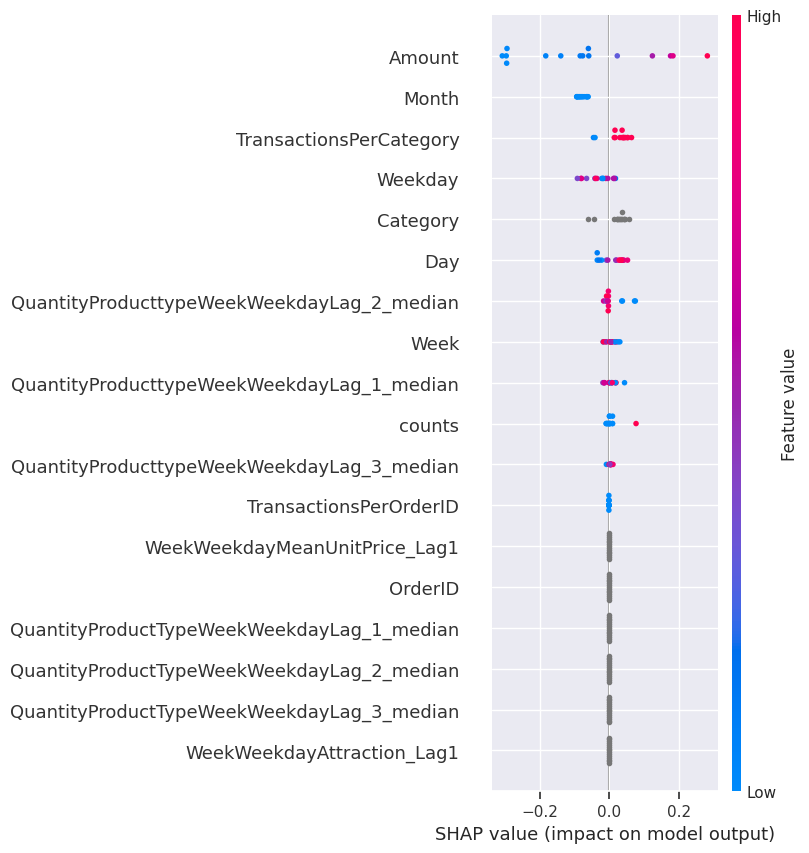

In [78]:
model.show_importances(kind=None)

Median absolute error: 0.3365599983402445


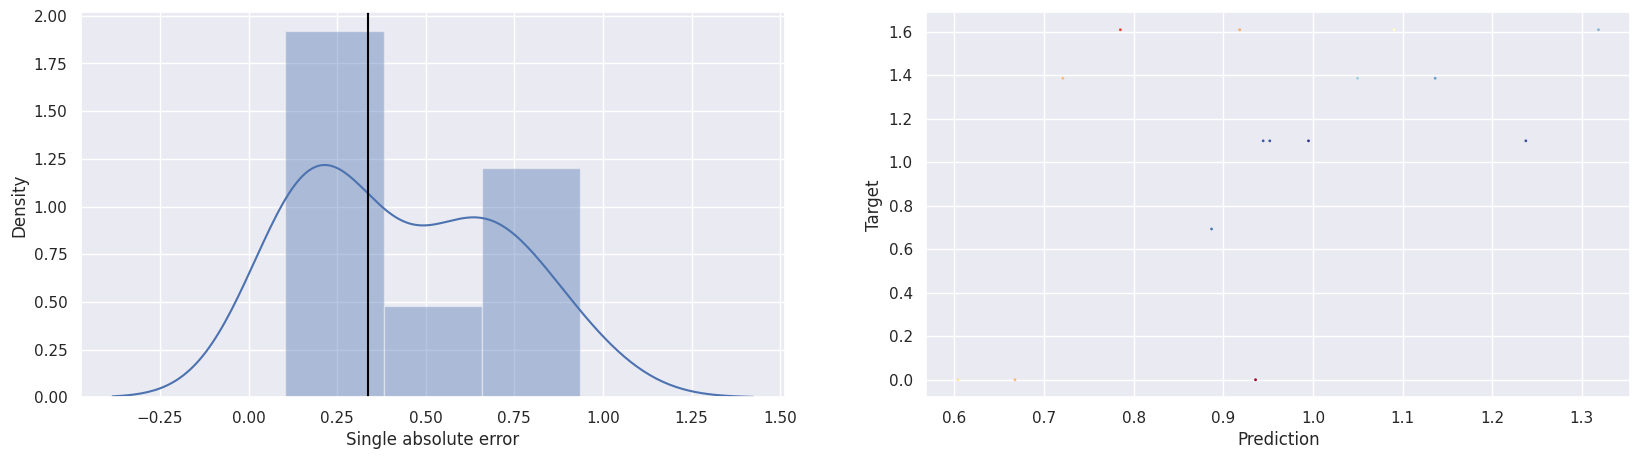

In [79]:
model.show_val_results();

In [80]:
np.mean(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

1.1931417797991892

In [81]:
np.median(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

0.9493742789338071